# Closed book question answering

* only two columns - `question` and `answer`, no context column, no additional documents for retrieval
* LLM as knowledge base where parameters store the facts of the world!

# Models
~ 56k rows of QA pairs. base variants ~100 M params suitable

* GPT2 - 137 M pre-trained on web data
* BART base - 109 M pretrained directly on question answering task, sentence entailment, dialogue response generation task and summarization
* T5 Base - 223 M  pre-trained on C4 (english web data)


In [1]:
!pip install pytextrank
!pip install datasets

In [11]:
from datasets import load_dataset

dataset = load_dataset("toughdata/quora-question-answer-dataset")
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 56402
    })
})

### Content
The dataset is in English language. There are several exact duplicate questions and only ~3k unique questions. 

In [40]:
question_set = {}
for i, q in enumerate(dataset["train"]["question"]):
    if q not in question_set:
        question_set[q] = []
    question_set[q].append(i)
print("total questions: ", len(question_set))
print("max answers for a single question: ", max(len(question_set[q]) for q in question_set))
print("min answers for a single question: ", min(len(question_set[q]) for q in question_set))


total questions:  3234
max answers for a single question:  106
min answers for a single question:  1


We can observe that questions have lengths upto 300 characters. Majority of them are short.

In [41]:
import plotly.express as px

q_lens = {"length": [len(ans) for ans in dataset['train']['question']]}

fig = px.histogram(q_lens, nbins=10, x='length')

fig.update_layout(title='Distribution of length of Questions',
                  xaxis_title='Length',
                  yaxis_title='Frequency',
                  bargap=0.2,
                  bargroupgap=0.1,)
		
fig.show()

But, the answers can be pretty long upto 450k characters. As majority of the answers are within 50k chars we discard the longer ones as they usually spam.
We however allow to keep multiple answers for each question. Each answer may focus on different aspects of the question. Also, we want to maintain diversity in the text because the main objective was to build a conversational and interesting QA agent.



In [42]:
import plotly.express as px

ans_lens = {"length": [len(ans) for ans in dataset['train']['answer']]}

fig = px.histogram(ans_lens, nbins=10, x='length')

fig.update_layout(title='Distribution of length of Answers',
                  xaxis_title='Length',
                  yaxis_title='Frequency',
                  bargap=0.2,
                  bargroupgap=0.1,)
		
fig.show()

# URLs 

broken, often spam, don't directly provide information

* questions containing urls: 6
* answers containing urls: 11404


In [34]:
import re

# Regular expression pattern to match URLs
url_pattern = r"https?://[^\s<>{}\"]+"

question_count = 0
answer_count = 0

for question in question_set:
    # Find all URLs in the document
    urls = re.findall(url_pattern, question)
    
    # Update the counter for this document
    if len(urls): 
        question_count += 1


for answer in dataset['train']['answer']:
    # Find all URLs in the document
    urls = re.findall(url_pattern, answer)
    
    # Update the counter for this document
    if len(urls): 
        answer_count += 1

print("# questions containing urls:", question_count)
print("# answers containing urls:", answer_count)


# questions containing urls: 6
# answers containing urls: 11404


# Bad Language

* popular forum, major task to moderate the content 
* [repo](https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words) list of common bad words.* Substring match and replacement
* questions containing bad words: 220
* applied to the answers after filtering and removing the longer ones. 


In [38]:
import requests
import re

def check_words_in_string(words, text):
    text = text.lower()
    for word in words:
        if word in text:
            return True
    return False

english_bad_words_url = "https://raw.githubusercontent.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words/master/en"

response = requests.get(english_bad_words_url)
word_list = response.content.decode().split('\n')
word_list = [word for word in word_list  if len(word) ]
question_count = 0

for question in question_set:
    if check_words_in_string(word_list, question): 
        question_count += 1

print("# questions containing bad words:", question_count)

# questions containing bad words: 220


# Answer summarization

* extract the important sentences and phrases from long answer using fast TextRank. 

* While finetuning, model only memorize the facts and not forget grammar

In [43]:

import spacy
import torch
import pytextrank
from tqdm import tqdm
import re



nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank")

MAX_LENGTH = 50_000 # remove answers longer than this


def process_answer(ans, max_tokens=500, num_sentences=20):
    if len(ans.split()) <= max_tokens:
        return ans
    # extractive summary
    doc = nlp(ans)
    top_sentences = [sent.text for sent in doc._.textrank.summary(limit_sentences=num_sentences)]
    summary = ""
    for sent in top_sentences:
        if len(summary.split()) + len(sent.split()) > max_tokens:
            break
        summary = summary + " " + sent
    return summary
   

def process_text(text, bad_word_list=word_list):
    # remove url
    clean_text = re.sub(r'http\S+', '', text)
    # Remove punctuation and special characters
    clean_text = re.sub(r'[^\w\s]', '', text)

    # Remove obscene words from the list of words
    for bad_word in bad_word_list:
        clean_text = clean_text.replace(bad_word, "")
    
    return clean_text

clean_data = {
    "question": [],
    "answer": []
}

for i, data in tqdm(enumerate(dataset["train"])):
    if len(data['answer']) > MAX_LENGTH:
        continue
    clean_data['question'].append(process_text(data['question']))
    clean_data['answer'].append(process_text(process_answer(data['answer'])))

/home/a/miniforge3/envs/nlp_/lib/python3.8/site-packages


56402it [04:26, 211.50it/s]


In [44]:
from datasets import Dataset

clean_dataset = Dataset.from_dict(clean_data)
clean_dataset.save_to_disk('clean_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/56382 [00:00<?, ? examples/s]

In [63]:
clean_dataset = Dataset.load_from_disk('clean_dataset')

In [64]:
new_set = {}
for i, q in enumerate(clean_dataset["question"]):
    if q not in new_set:
        new_set[q] = []
    new_set[q].append(i)

print("dataset size: ", len(clean_dataset))
print("total questions: ", len(new_set))

dataset size:  56382
total questions:  3234


We have the same number of unique questions as before pre-processing. We have not lost any question due to cleaning. We may want to further reduce the dataset size as we want to quickly fine-tune the LLMs but have limited compute.

Now, only a few of these answers for each question may be of relevance and high-quality. This especially true for Quora where there is little moderation compared to other forums like stackoverflow. We would like to filter the good answers. 
 Without relying human evaluators, we can use a capable llm to score these answers. This would be better than using heuristics like text similarity. Judging an answer can be a complex task as we don't have the voting information. Therefore, I am using a popular model  based on Microsoft's DeBERTa-v3-base. It was trained on multiple Natural Language Inference (NLI) datasets and is suitable for zero-shot classification. It has ~200M params and inference time is reasonable.


## Answer filtering

#### Zero shot answer classification
We want classify whether the given answer does actually answers the question or not. We can prompt with question and the given answer and ask whether it is reliable. Using the confidence score from the llm we can sort the answers. 
We can keep answers with the top $20\%$ of scores. This will result in ~5x reduction in dataset size.


In [66]:
from transformers import pipeline
import numpy as np
from math import  ceil
from tqdm import tqdm
import json
import torch
import pdb

threshold = 20 # select top threshold % of the answers
answer_judge = pipeline("zero-shot-classification", model= "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", device=0)

shortlisted_indices = []

for i, question in tqdm(enumerate(new_set)):
    scores = [] 
    prompts = [
        f"""
        Does the following answer reliably answer the question 
        {question}
        Answer: {clean_dataset['answer'][ans_index]}
        """
        for ans_index in new_set[question]
    ]
    candidate_labels = ["yes"]
    try:
        with torch.no_grad():
            res = answer_judge(prompts, candidate_labels)
            scores.extend([item['scores'][0] for item in res])
    except Exception as e:
        print(e)
    del res
    torch.cuda.empty_cache()
    sorted_indices = np.argsort(scores)
    total_selects = ceil(len(sorted_indices) * threshold/100)
    sorted_indices = sorted_indices[-total_selects:].tolist()
    select_indices = [new_set[question][index] for index in sorted_indices]
    shortlisted_indices.extend(select_indices)
    with open(f"../log/q_{i}.json", "w") as f:
        json.dump(select_indices, f)

print("remaining dataset size: ", len(shortlisted_indices))

0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
3234it [1:04:09,  1.19s/it]

remaining dataset size:  12710


In [67]:
reduced_dataset = clean_dataset[shortlisted_indices]
reduced_dataset = Dataset.from_dict(reduced_dataset)
reduced_dataset.save_to_disk('reduced_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/12710 [00:00<?, ? examples/s]

In [68]:
from datasets import Dataset
reduced_dataset = Dataset.load_from_disk('reduced_dataset')

## Question Text Analysis

We would now study the question text to understand the important topics in the dataset.


1. Tokenize each questions into list of words
2. Remove the non-alphanumeric characters as the dataset was listed as English only in the HuggingFace. So, we wouldn't lose much information by discarding the other symbols. We  should preserve the case so as not to lose information about acronyms or emphasis context. We also keep the digits as the question may involve years or math.
3. Stop word removal
4. Lemmatization - as it gives more meaningful words compared to stemming. This is particularly useful for topic modelling. We have only ~3k questions so the higher computational complexity is still practical. 
5. POS tagging to identify nouns. most words are not very informative as they are just used in constructing the questions. We only select nouns as they can be informative for topic modelling.

In [69]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

questions = list(new_set.keys())

# tokenize
docs = [word_tokenize(question) for question in questions]

# remove non alphanumeric
questions = [re.sub(r'\W+', '', doc)  for doc in questions]


# stop word removal
no_stop_doc = [[token.lower() for token in doc if token not in stop_words] for doc in docs]


# lemmatize
lemmatized = [[lemmatizer.lemmatize(token) for token in doc] for doc in no_stop_doc]

# part-of-speech (POS) tagging to identify the nouns
pos_tags = [[word for word, pos in nltk.pos_tag(doc) if pos.startswith(('NN'))] for doc in lemmatized]


flatten_tokens = [token for doc in pos_tags for token in doc if len(token) > 1]

unique_tokens = {}
for token in flatten_tokens:
    if token not in unique_tokens:
        unique_tokens[token] = 0
    unique_tokens[token] += 1

print("num unique tokens: ", len(unique_tokens))

[nltk_data] Downloading package stopwords to /home/a/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/a/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


num unique tokens:  4925


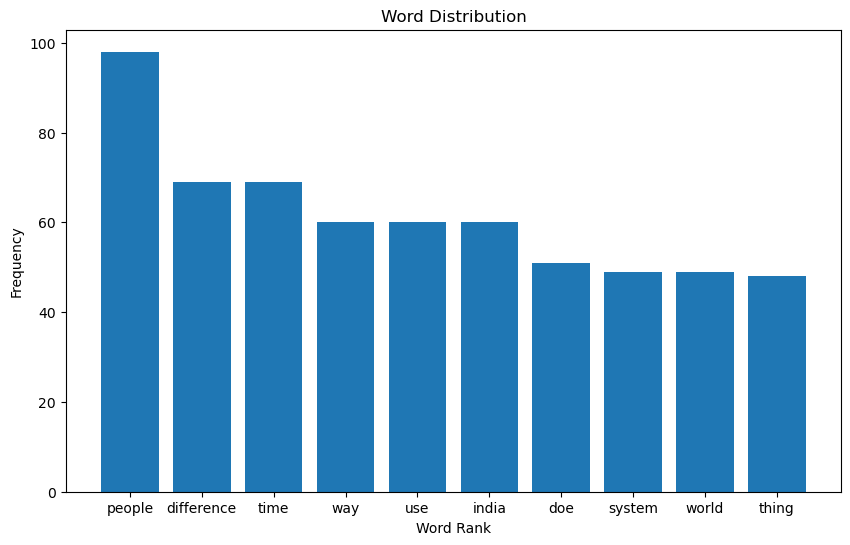

In [70]:
import matplotlib.pyplot as plt
from collections import Counter


word_freq = Counter(flatten_tokens)

# Get the most common words and their frequencies
num_words = 10
most_common_words = word_freq.most_common(num_words)

# Plot the word frequencies
plt.figure(figsize=(10, 6))
plt.bar(range(num_words), [freq for word, freq in most_common_words])
plt.xlabel("Word Rank")
plt.ylabel("Frequency")
plt.title("Word Distribution")
plt.xticks(range(num_words), [word for word, freq in most_common_words]);

In [71]:
import gensim.models.ldamulticore as ldamulticore

# Assuming you have a corpus named 'corpus', a dictionary named 'dictionary', and the desired number of topics 'num_topics'
from gensim.corpora import Dictionary
import logging
from pprint import pprint

# Create the dictionary and corpus
dictionary = Dictionary(pos_tags)
corpus = [dictionary.doc2bow(text) for text in lemmatized]

# Set training parameters.
num_topics = 4
chunksize = 3500
passes = 100
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = ldamulticore.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [70]:
for idx, topic in model.print_topics():
    print(f"Topic {idx}: {topic}")

2024-07-30 14:31:54,833 : INFO : topic #0 (0.250): 0.008*"country" + 0.006*"number" + 0.005*"travel" + 0.005*"language" + 0.004*"people" + 0.004*"life" + 0.004*"system" + 0.004*"say" + 0.004*"ancient" + 0.004*"kind"
2024-07-30 14:31:54,834 : INFO : topic #1 (0.250): 0.069*"i" + 0.018*"get" + 0.008*"dog" + 0.006*"use" + 0.006*"want" + 0.004*"difference" + 0.004*"im" + 0.004*"buy" + 0.004*"india" + 0.004*"cat"
2024-07-30 14:31:54,835 : INFO : topic #2 (0.250): 0.010*"i" + 0.009*"good" + 0.008*"use" + 0.008*"people" + 0.008*"think" + 0.007*"one" + 0.006*"know" + 0.005*"way" + 0.005*"make" + 0.005*"system"
2024-07-30 14:31:54,835 : INFO : topic #3 (0.250): 0.020*"i" + 0.007*"one" + 0.007*"india" + 0.006*"doe" + 0.005*"make" + 0.004*"learn" + 0.004*"difference" + 0.004*"mean" + 0.004*"show" + 0.003*"war"


Topic 0: 0.008*"country" + 0.006*"number" + 0.005*"travel" + 0.005*"language" + 0.004*"people" + 0.004*"life" + 0.004*"system" + 0.004*"say" + 0.004*"ancient" + 0.004*"kind"
Topic 1: 0.069*"i" + 0.018*"get" + 0.008*"dog" + 0.006*"use" + 0.006*"want" + 0.004*"difference" + 0.004*"im" + 0.004*"buy" + 0.004*"india" + 0.004*"cat"
Topic 2: 0.010*"i" + 0.009*"good" + 0.008*"use" + 0.008*"people" + 0.008*"think" + 0.007*"one" + 0.006*"know" + 0.005*"way" + 0.005*"make" + 0.005*"system"
Topic 3: 0.020*"i" + 0.007*"one" + 0.007*"india" + 0.006*"doe" + 0.005*"make" + 0.004*"learn" + 0.004*"difference" + 0.004*"mean" + 0.004*"show" + 0.003*"war"


topics 
1. High level overall concepts - like country, travel, language, people, life.
2. popular topics like dog, cat and India 
3. verbs - use, think, and, make
4. most common words in questions - like what is the `difference`, how to `make`, how to `learn`, what does it `mean`, how to `show`.

# Finetuning

We first set seeds to ensure reproducibility. 

In [31]:
import torch
import numpy as np
#  Set random seeds
seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

For questions answering task, ROUGE is the most relevant metric. It measures whether the model is able to recall all the information.
BLEU is not particularly useful as it enforces that the given and generated answer should match. Quora users are from all around the world and can make grammatical mistakes. 
F1 score gives a balanced weight to precision and recall.

Then we split the dataset into train, dev (val) and test.

In [50]:
from datasets import Dataset
dataset = Dataset.load_from_disk('reduced_dataset')
dataset_train_test_val = dataset.train_test_split(test_size=0.2, seed=seed)
dataset_test_val = dataset_train_test_val['test'].train_test_split(test_size=0.5, seed=seed)
train_data = dataset_train_test_val['train']
dev_data = dataset_test_val['train']
test_data = dataset_test_val['test']

## T5

### Hyperparameters

Learning rate :  3e-4 works well for QA as reported [here](https://huggingface.co/docs/transformers/model_doc/t5)

Weight decay : 0.01  (from [here](https://huggingface.co/docs/transformers/tasks/summarization))

number of epochs : 4


We first evaluate the pre-trained model directly to see how well it does. We can also test how much improvement after fine-tuning.


In [78]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

import numpy as np
import nltk
from transformers import TrainingArguments, Trainer
import evaluate


def preprocess_function(examples, prompt_pref="Answer the following question "):
    """Add prefix to the sentences, tokenize the text, and set the labels"""
    # The "inputs" are the tokenized question:
    inputs = [prompt_pref + doc for doc in examples["question"]]
    model_inputs = tokenizer(inputs, max_length=300, truncation=True)
    
    # The "labels" are the tokenized answer:
    labels = tokenizer(text_target=examples["answer"], max_length=512, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result


nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

model = "google-t5/t5-base"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSeq2SeqLM.from_pretrained(model)



data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

test_data_cur = test_data.map(preprocess_function, batched=True)
train_data_cur = train_data.map(preprocess_function, batched=True)
dev_data_cur = dev_data.map(preprocess_function, batched=True)



training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=1000,
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False
)

# Set up trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data_cur,
    eval_dataset=dev_data_cur,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.evaluate(test_data_cur)

Map:   0%|          | 0/10168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1271 [00:00<?, ? examples/s]

/home/a/miniforge3/envs/nlp_/lib/python3.8/site-packages/transformers/training_args.py:1525: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

/home/a/miniforge3/envs/nlp_/lib/python3.8/site-packages/accelerate/accelerator.py:488: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 5.80 GiB of which 7.25 MiB is free. Including non-PyTorch memory, this process has 1.75 GiB memory in use. Process 71705 has 4.02 GiB memory in use. Of the allocated memory 1.53 GiB is allocated by PyTorch, and 130.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Continued the executtion of this cell in this [kaggle notebook](https://www.kaggle.com/code/amanatman/finetuning-t5-base/edit). view the runs in this [wandb workspace](https://wandb.ai/willtryagain/huggingface/workspace?nw=nwuserwilltryagain)

### Direct evaluation results
Tested the model on test set directly without fine-tuning to evaluate how much the pre-training was useful.

In [3]:
{'eval_loss': 12.867426872253418,
 'eval_rouge1': 0.0832278983133116,
 'eval_rouge2': 0.013059462924019393,
 'eval_rougeL': 0.06819647592317876,
 'eval_rougeLsum': 0.06705824708511707,
 'eval_runtime': 191.9669,
 'eval_samples_per_second': 6.621,
 'eval_steps_per_second': 1.657}

{'eval_loss': 12.867426872253418,
 'eval_rouge1': 0.0832278983133116,
 'eval_rouge2': 0.013059462924019393,
 'eval_rougeL': 0.06819647592317876,
 'eval_rougeLsum': 0.06705824708511707,
 'eval_runtime': 191.9669,
 'eval_samples_per_second': 6.621,
 'eval_steps_per_second': 1.657}

## Fine-tuned results

Please view the direct run (here) [https://www.kaggle.com/code/amanatman/finetuning-t5-base]. 

We see the performance has degraded. It is because of the small dataset and high learning rate. It is overfitting.

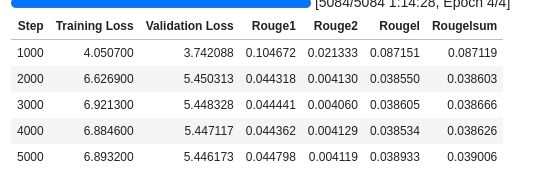

In [5]:

{'eval_loss': 5.449681758880615,
 'eval_rouge1': 0.04247785128936092,
 'eval_rouge2': 0.0036574391221630134,
 'eval_rougeL': 0.03766044705476286,
 'eval_rougeLsum': 0.03766584025398295,
 'eval_runtime': 194.2314,
 'eval_samples_per_second': 6.544,
 'eval_steps_per_second': 1.637,
 'epoch': 4.0}

{'eval_loss': 5.449681758880615,
 'eval_rouge1': 0.04247785128936092,
 'eval_rouge2': 0.0036574391221630134,
 'eval_rougeL': 0.03766044705476286,
 'eval_rougeLsum': 0.03766584025398295,
 'eval_runtime': 194.2314,
 'eval_samples_per_second': 6.544,
 'eval_steps_per_second': 1.637,
 'epoch': 4.0}

# BART-base

We have continued the run on this [colab file](https://colab.research.google.com/drive/1p6T3ipgigcRl4g1-qZa9c-1bPQ6A-d9O#scrollTo=ojDRsDmHZi4g). I am parallely running multiple notebooks so have linked these files.

### Direct evaluation results
Tested the model on test set directly without fine-tuning to evaluate how much the pre-training was useful.

In [ ]:
{'eval_loss': 8.868888854980469,
 'eval_rouge1': 0.09534993533989135,
 'eval_rouge2': 0.018468234455015126,
 'eval_rougeL': 0.07437223782499246,
 'eval_rougeLsum': 0.07958705476630477,
 'eval_runtime': 131.5141,
 'eval_samples_per_second': 9.664,
 'eval_steps_per_second': 2.418}

BART performs better than T5 in all the metrics. It is even faster to run because of fewer parameters.

## Fine-tuned results

As seen the above 
We see the performance has improved for bart. It doesn't even overfit for the same learning rate.


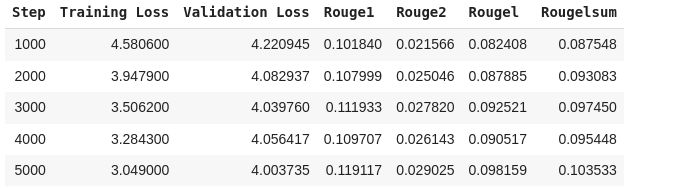

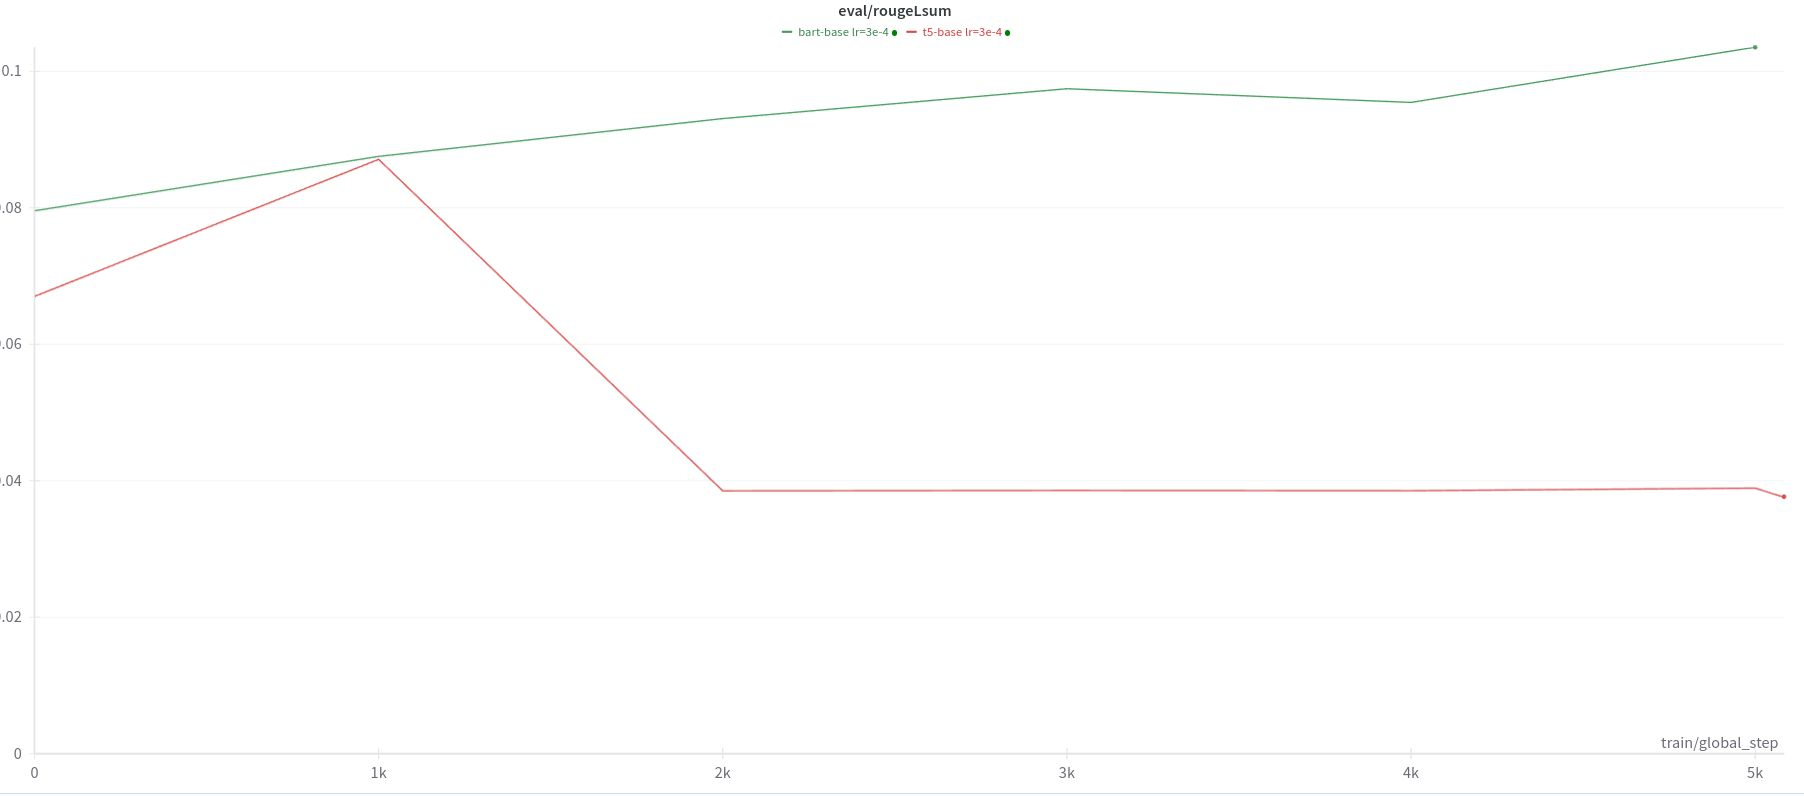

In [6]:
{'eval_loss': 4.014970302581787,
 'eval_rouge1': 0.11557184994660916,
 'eval_rouge2': 0.03028696341919042,
 'eval_rougeL': 0.09471518751568625,
 'eval_rougeLsum': 0.10036136814097385,
 'eval_runtime': 124.3135,
 'eval_samples_per_second': 10.224,
 'eval_steps_per_second': 2.558,
 'epoch': 4.0}

{'eval_loss': 4.014970302581787,
 'eval_rouge1': 0.11557184994660916,
 'eval_rouge2': 0.03028696341919042,
 'eval_rougeL': 0.09471518751568625,
 'eval_rougeLsum': 0.10036136814097385,
 'eval_runtime': 124.3135,
 'eval_samples_per_second': 10.224,
 'eval_steps_per_second': 2.558,
 'epoch': 4.0}

GPT2 is trained on web data which contains a lot of unfiltered content from the internet, which is far from neutral. Open-AI has warned that "GPT-2 do not distinguish fact from fiction, we don’t support use-cases that require the generated text to be true." It doesn't make sense to use gpt for finetuning for QA, apart from the time constraints.

We therefore can now focus on improving BART as it is more promising.

## 1. Data augmentation

As we have a small training set size ~10k samples, we can add more samples by augmenting the existing ones. It will also make the model more robust against the diverse data - by simulating spelling mistakes and synonym replacements. 



NLPaug is a standard open-source library for this purpose. We apply these to questions only as the model is expected to answer any given question. 
This will increase training data to 12k.


In [56]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

def apply_augmentation(question, p=0.5):
    spelling_aug = naw.SpellingAug() # common spelling mistakes
    if np.random.binomial(1, p):
        question = spelling_aug.augment(question)
    synonym_aug = naw.SynonymAug(aug_src='wordnet') 
    if np.random.binomial(1, p):
        question = synonym_aug.augment(question)
    if isinstance(question, list):
        return question[0]
    return question


questions = train_data['question']
answers = train_data['answer']

aug_per = 0.20 
num_indices_to_sample = int(aug_per * len(train_data))
sampled_indices = np.random.choice(np.arange(len(train_data)), num_indices_to_sample, replace=False)
print("# added samples: ", num_indices_to_sample)

for i in sampled_indices:
    questions.append(apply_augmentation(questions[i]))
    answers.append(answers[i])

# added samples:  2033


In [58]:
aug_train_dataset = Dataset.from_dict({
    "question": questions,
    "answer": answers
})

aug_train_dataset.save_to_disk("aug_data")

Saving the dataset (0/1 shards):   0%|          | 0/12201 [00:00<?, ? examples/s]

We now have a dataset of size 15k with added augmentations.

We can test if more data indeed helps the model. We would evaluate on the original test set.

In [54]:
train_data

Dataset({
    features: ['question', 'answer'],
    num_rows: 10168
})

## Results

View run [here](https://www.kaggle.com/code/amanatman/augmented-data) and [visualization](https://wandb.ai/willtryagain/huggingface?nw=nwuserwilltryagain)

In [59]:
{'eval_loss': 4.105648994445801,
 'eval_rouge1': 0.11471782132064401,
 'eval_rouge2': 0.027543319644675598,
 'eval_rougeL': 0.09366082454778155,
 'eval_rougeLsum': 0.09904293465569898,
 'eval_runtime': 122.7085,
 'eval_samples_per_second': 10.358,
 'eval_steps_per_second': 2.592,
 'epoch': 4.0}

{'eval_loss': 4.105648994445801,
 'eval_rouge1': 0.11471782132064401,
 'eval_rouge2': 0.027543319644675598,
 'eval_rougeL': 0.09366082454778155,
 'eval_rougeLsum': 0.09904293465569898,
 'eval_runtime': 122.7085,
 'eval_samples_per_second': 10.358,
 'eval_steps_per_second': 2.592,
 'epoch': 4.0}

We observe the dev and test performance marginally drops after augmentation. This may be because the augmented data is still just based on training data. The training loss is the least sofar, so  it is overfitting. We will decrease the lr.

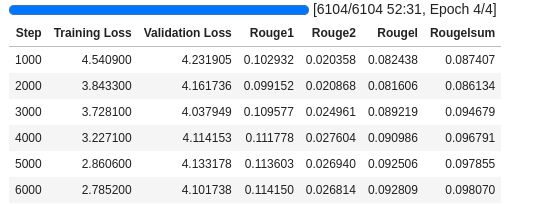

## QA - AQ

#### Predict the question

We can give the llm more complete knowledge of the dataset by also asking it to predict the question for a given answer. 

1. finetune the llm to predict the question for each answer.
2. then, finetune it on the original task of answer generation.

The motivation is that multi-task learning will make the llm more generalizable and improve data efficiency.

We use a small learning rate of 2e-5 in order to prevent overfitting. [tutorial](https://huggingface.co/docs/transformers/tasks/summarization)

### Results
https://www.kaggle.com/code/amanatman/both-qa-aq-task


There is drop in test loss.

In [72]:
{'eval_loss': 3.8308377265930176,
 'eval_rouge1': 0.10713393552432526,
 'eval_rouge2': 0.026072663781513985,
 'eval_rougeL': 0.0866462875242594,
 'eval_rougeLsum': 0.0917150463200469,
 'eval_runtime': 124.9659,
 'eval_samples_per_second': 10.171,
 'eval_steps_per_second': 2.545,
 'epoch': 4.0}

{'eval_loss': 3.8308377265930176,
 'eval_rouge1': 0.10713393552432526,
 'eval_rouge2': 0.026072663781513985,
 'eval_rougeL': 0.0866462875242594,
 'eval_rougeLsum': 0.0917150463200469,
 'eval_runtime': 124.9659,
 'eval_samples_per_second': 10.171,
 'eval_steps_per_second': 2.545,
 'epoch': 4.0}